# Hybrid Deep Learning Model
# SOM + ANN Model

On Credit card fraud detection dataset first we apply unsupervised learning - SOM and the supervised learning - ANN

In [34]:
# Import the libraries
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [35]:
# Import dataset
dataset = pd.read_csv("./Self_Organizing_Maps/Credit_Card_Applications.csv")
dataset.head()

,CustomerID,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,Class
0,15776156,1,22.08,11.46,2,4,4,1.585,0,0,0,1,2,100,1213,0
1,15739548,0,22.67,7.00,2,8,4,0.165,0,0,0,0,2,160,1,0
2,15662854,0,29.58,1.75,1,4,4,1.250,0,0,0,1,2,280,1,0
3,15687688,0,21.67,11.50,1,5,3,0.000,1,1,11,1,2,0,1,1
4,15715750,1,20.17,8.17,2,6,4,1.960,1,1,14,0,2,60,159,1


In [36]:
dataset[dataset['CustomerID']==3901993731364]

,CustomerID,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,Class


### Identify the fraud with Self-Organising maps (Refer SOM_tut7)

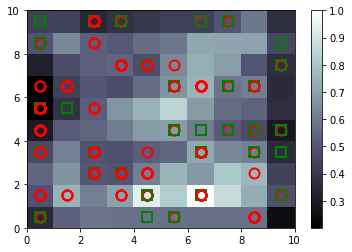

In [39]:
from sklearn.preprocessing import MinMaxScaler
from minisom import MiniSom
from pylab import bone, pcolor, colorbar, plot, show

## Select relevant data from dataset
X = dataset.iloc[:,:-1].values  # [:,:-1] -> all rows & allcolumns except the last column.
y = dataset.iloc[:,-1].values   # [:,-1] -> all values of last class columns

## Feature Scaling
scaler = MinMaxScaler(feature_range=(0,1))  # feature_range -> we want our dataset to be in range 0 to 1
X = scaler.fit_transform(X) # fit(X) provides all the info scaler needs to perform normalization & transform(X) stores the normalized value in X

## Define SOM object
som = MiniSom(x=10, y=10, input_len=15, sigma=1.0, learning_rate=0.5)  # This object is a SOM that will be trained on X only

# Initialize Random weights
som.random_weights_init(X)        # random_weights_init(data) 

# Train the SOM on X & identify patterns
som.train_random(data = X, num_iteration=100)       # train_random(data, num_iteration -> no. of times data should be repeated on model)

## Visualizing the results
bone()  # Initialize the figure - i.e. define the window that will contain the map
pcolor(som.distance_map().T)  # Put different winning nodes on map 
colorbar()     # update legend 

markers = ['o','s']  # o -> circle & s -> square
colors = ['r','g']   # r -> red & g -> green
  

for i, x in enumerate(X):   # i-> index to move through rows & x -> vector/list of all feature values of a customer at index i.
    
    # Get winning node for a customer
    w = som.winner(x)
    
    # For the above winning node, place the marker on it. 
    # In SOM, each winning node is represented by square as shown in above heatmap.
    # & we basically want to put the marker at the center of the square for which we require its co-ordinates.
    plot(w[0]+0.5, w[1]+0.5, markers[y[i]], markeredgecolor = colors[y[i]],
        markerfacecolor = 'None', markersize = 10, markeredgewidth = 2)
                            # y[i] = 0 or 1
                            # We are not coloring the marker, bcoz at a winning node, we can have multiple markers

show()   # Show the graph


In [40]:
## finding frauds using the mapping
mappings = som.win_map(X)

frauds = np.concatenate((mappings[(6,1)], mappings[(4,1)]), axis=0)       # Form a list of all potential customers                                   
frauds = scaler.inverse_transform(frauds)    # Inverse the scaling

print(frauds[:,0][0])

15587297.0


### Going from supervised to unsupervised Deep learning Model

In [41]:
# Creating matrix of features
customers = dataset.iloc[:,1:].values    # Except the customer Id, all the columns may be useful in determining if there is a fraud


# Creating the dependent variable
'''
This will be a variable that denotes if there is a fraud or not (1 or 0 resp).
So we use the potential list of customers who did fraud provided by our SOM model.
'''
# This can be done in 2 ways:-

### --------- Method 1: Adding dependable variable using apply() -------------

is_fraud =  dataset['CustomerID'].apply(lambda x: 1 if x in frauds[:,0] else 0).values


### --------- Method 2: Adding the dependable variable using for loop-------------
'''
## Step 1: Initialize the output variable as a vector of 0s
#is_fraud = np.zeros(len(dataset))
is_fraud = np.zeros(dataset.shape[0])

## Step 2: Replace 0 with 1 for potential fraud customers
for i in range(len(dataset)):
    if dataset.iloc[i,0] in frauds:
        is_fraud[i] = 1
'''
#print(is_fraud)

'\n## Step 1: Initialize the output variable as a vector of 0s\n#is_fraud = np.zeros(len(dataset))\nis_fraud = np.zeros(dataset.shape[0])\n\n## Step 2: Replace 0 with 1 for potential fraud customers\nfor i in range(len(dataset)):\n    if dataset.iloc[i,0] in frauds:\n        is_fraud[i] = 1\n'

In [43]:
# *****  Forming the ANN model ***********

# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
customers  = sc.fit_transform(customers)

# Building ANN
ann_classifier = tf.keras.models.Sequential()   # Initialize ann as a sequence of layers
ann_classifier.add(tf.keras.layers.Dense(units=2, activation='relu', kernel_initializer='uniform', input_dim=15))   # Dense(units -># To add fully connected layer into ANN, use the dense class
ann_classifier.add(tf.keras.layers.Dense(units=1, activation='sigmoid', kernel_initializer='uniform'))   # Add output layer

ann_classifier.compile(optimizer= 'adam' , loss='binary_crossentropy' , metrics= ['accuracy'] ) # Compile the ANN with optimizer/loss function

ann_classifier.fit(customers, is_fraud, batch_size=2, epochs=5 )  # Here we have few observations & features


Epoch 1/5
345/345 [==============================] - 1s 3ms/step - loss: 0.5806 - accuracy: 0.9507
Epoch 2/5
345/345 [==============================] - 1s 3ms/step - loss: 0.3641 - accuracy: 0.9536
Epoch 3/5
345/345 [==============================] - 1s 4ms/step - loss: 0.2500 - accuracy: 0.9536
Epoch 4/5
345/345 [==============================] - ETA: 0s - loss: 0.1691 - accuracy: 0.95 - 2s 6ms/step - loss: 0.1702 - accuracy: 0.9536
Epoch 5/5
345/345 [==============================] - 1s 4ms/step - loss: 0.1375 - accuracy: 0.9536
